In [36]:
import os

import libs_cleo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

# 确保 Matplotlib 图表正确显示在 Jupyter 中
%matplotlib inline

In [37]:
def batch_draw(path_s1,path_ssies3):
    file_s1 = libs_cleo.NcFile(path_s1)
    data_s1 = file_s1.original_data
    file_ssies3 = libs_cleo.CDFFile(path_ssies3)
    data_ssies3 = file_ssies3.data
    
    start_time_for_title = file_ssies3.start_time_datetime
    vxraw_set_nan = file_ssies3.vxraw_set_nan()
    
    start_idx,end_idx = file_ssies3.return_start_end_idx()
    data = libs_cleo.walen_test_s1_sseis3(data_s1=data_s1,data_ssies3=data_ssies3,start_idx=start_idx,end_idx=end_idx,vxraw_set_nan=vxraw_set_nan)
    data['vx'] = data['vx'].interpolate(method='linear')
    data['diff_bx'] = data['diff_bx'].interpolate(method='linear')
    bandpassfilter_vx = libs_cleo.BandPassFilter(data['vx'], data['Epoch'], start_time_for_title=start_time_for_title)
    bandpassfilter_diff_bx = libs_cleo.BandPassFilter(data['diff_bx'], data['Epoch'], start_time_for_title=start_time_for_title)
    
    # 创建figure
    fig = plt.figure(figsize=(25,140))
    # 设置GridSpec布局
    gs = gridspec.GridSpec(14,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0],sharex=ax1)
    ax4 = fig.add_subplot(gs[1, 1],sharex=ax1)
    # freq amp
    ax5 = fig.add_subplot(gs[2, :])
    ax6 = fig.add_subplot(gs[3, :])
    # bandpass filter 2 sides
    # (ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16) = (fig.add_subplot(gs[i, :]) for i in range(4,14))
    
    # 
    ax1.plot(data_ssies3['Epoch'],data_ssies3['vxraw'])
    ax1.set_xlim(data_ssies3['Epoch'].iloc[0],data_ssies3['Epoch'].iloc[-1])
    ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,15,30,45]))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.set_xlabel("time (s)")
    ax1.set_ylabel("vxraw (m/s)")
    ax1.set_title(f'original vx start at {start_time_for_title}')
    # 
    ax2.plot(vxraw_set_nan)
    ax2.set_xlabel("index")
    ax2.set_ylabel("vxraw (m/s)")
    ax2.set_title(f'vx after set nan {start_time_for_title}')
    #
    ax3.plot(data_ssies3['Epoch'],data_ssies3['glat'])
    ax3.set_xlabel("time (s)")
    ax3.set_ylabel("latitude")
    ax3.set_title(f'latitude {start_time_for_title}')
    # diff_bx
    ax4.plot(data_s1['Epoch'],data_s1['diff_b_for'])
    ax4.set_xlabel("time (s)")
    ax4.set_ylabel("diff_bx (nT)")
    ax4.set_title(f'diff_bx {start_time_for_title}')
    # 频谱lg vx
    ax5.plot(bandpassfilter_vx.final_freqs,np.log(bandpassfilter_vx.final_magnitudes))
    ax5.set_xlabel("frequency (hz)")
    ax5.set_ylabel("amplitude (lg)")
    ax5.set_title(f'vxraw frequency-amplitude {start_time_for_title}')
    # 频谱lg diff_bx
    ax6.plot(bandpassfilter_diff_bx.final_freqs,np.log(bandpassfilter_diff_bx.final_magnitudes))
    ax6.set_xlabel("frequency (hz)")
    ax6.set_ylabel("amplitude (lg)")
    ax6.set_title(f'diff_bx frequency-amplitude {start_time_for_title}')
    # bandpass 2 sides
    # 1
    for epoch1,epoch2,ax in zip([10,15,25,40,60,100,160,250,400,630],[15,25,40,60,100,160,250,400,630,1000],(fig.add_subplot(gs[i, :]) for i in range(4,14))):
        vx_filtered = bandpassfilter_vx.signal_after_bandpass_filter(epoch1=epoch1, epoch2=epoch2)
        diff_bx_filtered = bandpassfilter_diff_bx.signal_after_bandpass_filter(epoch1=epoch1, epoch2=epoch2)
        ax.set_title(f"after bandpass filter (epoch1={epoch1},epoch2={epoch2}) {start_time_for_title}")
        color = 'tab:red'
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('vxraw (m/s)')
        ax.plot(data['Epoch'], vx_filtered, color=color)
        ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,15,30,45]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # 格式化显示格式
        ax.tick_params(axis='y', labelcolor=color)
        # 创建第二个坐标轴，共享同一个x轴
        ax_right = ax.twinx()  
        color = 'tab:blue'
        ax_right.set_ylabel('diff_bx (nT)', color=color)
        ax_right.plot(data['Epoch'], diff_bx_filtered, color=color)
        ax_right.tick_params(axis='y', labelcolor=color)
    return fig


def save_fig(fig_save_path,path_s1,path_ssies3):
    if not os.path.exists(fig_save_path):
        os.makedirs(fig_save_path)
    fig = batch_draw(path_s1,path_ssies3)
    # 构建保存图像的完整路径
    save_fig_path = os.path.join(fig_save_path, f'walen_test_{libs_cleo.CDFFile(path_ssies3).start_time_str}.png')
    # 保存图像
    fig.savefig(save_fig_path)
    # 关闭图像以释放内存
    plt.close(fig)
    print(f'walen_test_{libs_cleo.CDFFile(path_ssies3).start_time_str}.png 已保存')

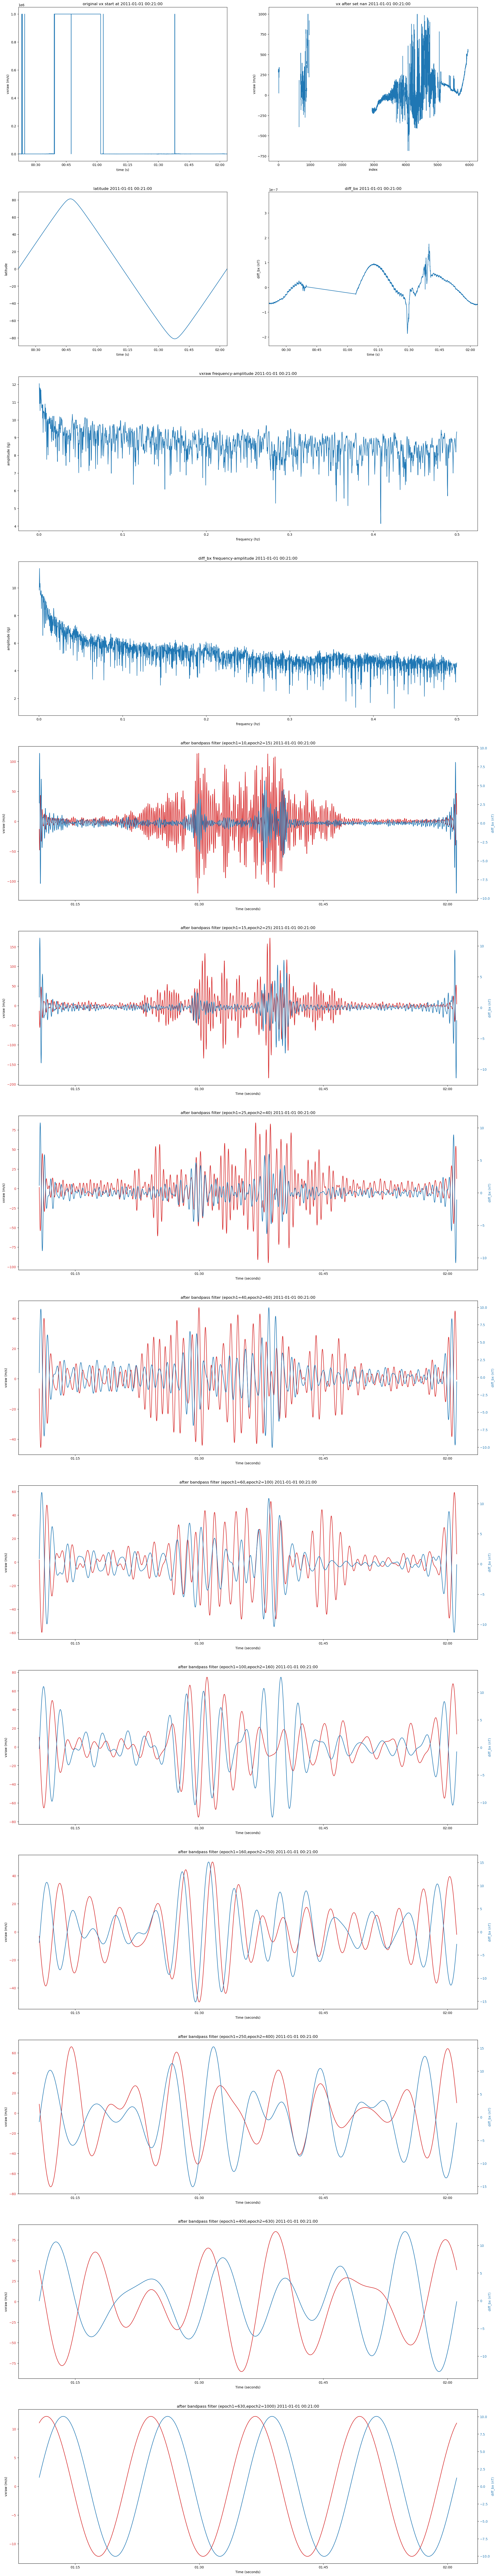

In [38]:
path_s1 = r"G:\0_postgraduate\DMSP\data\2011\18s1\dms_20110101_18s1.001.nc"
path_ssies3 = r"G:\0_postgraduate\DMSP\data\2011\ssies3\dmsp-f18_ssies-3_thermal-plasma_201101010021_v01.cdf"
fig = batch_draw(path_s1,path_ssies3)

In [39]:
path_s1 = r"G:\0_postgraduate\DMSP\data\2011\18s1\dms_20110101_18s1.001.nc"
path_ssies3 = r"G:\0_postgraduate\DMSP\data\2011\ssies3\dmsp-f18_ssies-3_thermal-plasma_201101010021_v01.cdf"
fig_save_path = r"G:\0_postgraduate\DMSP\fig\2011\walen_test"
fns = ['dmsp-f18_ssies-3_thermal-plasma_201101010021_v01.cdf','dmsp-f18_ssies-3_thermal-plasma_201101010203_v01.cdf',
       'dmsp-f18_ssies-3_thermal-plasma_201101010345_v01.cdf','dmsp-f18_ssies-3_thermal-plasma_201101010527_v01.cdf',
       'dmsp-f18_ssies-3_thermal-plasma_201101010709_v01.cdf','dmsp-f18_ssies-3_thermal-plasma_201101010851_v01.cdf',
       'dmsp-f18_ssies-3_thermal-plasma_201101011033_v01.cdf','dmsp-f18_ssies-3_thermal-plasma_201101011215_v01.cdf',
       'dmsp-f18_ssies-3_thermal-plasma_201101011357_v01.cdf','dmsp-f18_ssies-3_thermal-plasma_201101011539_v01.cdf',
       'dmsp-f18_ssies-3_thermal-plasma_201101011721_v01.cdf','dmsp-f18_ssies-3_thermal-plasma_201101011903_v01.cdf',
       'dmsp-f18_ssies-3_thermal-plasma_201101012045_v01.cdf']
for fn in fns:
    path_ssies3 = rf"G:\0_postgraduate\DMSP\data\2011\ssies3\{fn}"
    try:
        save_fig(fig_save_path,path_s1=path_s1,path_ssies3=path_ssies3)
    except Exception as e:
        print(e)

# save_fig(fig_save_path,path_s1=path_s1,path_ssies3=path_ssies3)

walen_test_201101010021.png 已保存
walen_test_201101010203.png 已保存
walen_test_201101010345.png 已保存
walen_test_201101010527.png 已保存
walen_test_201101010709.png 已保存
walen_test_201101010851.png 已保存
walen_test_201101011033.png 已保存
walen_test_201101011215.png 已保存
"['Epoch'] not in index"
"['Epoch'] not in index"
"['Epoch'] not in index"
walen_test_201101011903.png 已保存
"['Epoch'] not in index"


In [40]:
#     
# 
# 
# path_s1 = r"G:\0_postgraduate\DMSP\data\2011\18s1\dms_20101231_18s1.001.nc"
# fns = ['dmsp-f18_ssies-3_thermal-plasma_201101010021_v01.cdf','dmsp-f18_ssies-3_thermal-plasma_201101010203_v01.cdf',
#        'dmsp-f18_ssies-3_thermal-plasma_201101010345_v01.cdf','dmsp-f18_ssies-3_thermal-plasma_201101010527_v01.cdf',
#        'dmsp-f18_ssies-3_thermal-plasma_201101010709_v01.cdf','dmsp-f18_ssies-3_thermal-plasma_201101010851_v01.cdf',
#        'dmsp-f18_ssies-3_thermal-plasma_201101011033_v01.cdf','dmsp-f18_ssies-3_thermal-plasma_201101011215_v01.cdf',
#        'dmsp-f18_ssies-3_thermal-plasma_201101011357_v01.cdf','dmsp-f18_ssies-3_thermal-plasma_201101011539_v01.cdf',
#        'dmsp-f18_ssies-3_thermal-plasma_201101011721_v01.cdf','dmsp-f18_ssies-3_thermal-plasma_201101011903_v01.cdf',
#        'dmsp-f18_ssies-3_thermal-plasma_201101012045_v01.cdf']
# for fn in fns:
#     path_ssies3 = r"G:\0_postgraduate\DMSP\data\2011\ssies3/" + fn
#     try:
#         save_fig(fig_save_path,path_s1=path_s1,path_ssies3=path_ssies3)
#     except Exception as e:
#         print(e)